In [1]:
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Download and prep Data

In [2]:
#download data
!aws s3 cp s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet NFL_PBP_Data_2010_2022_original.parquet

download: s3://capstone-nfl-data/NFL_PBP_Data_2010_2022_original.parquet to ./NFL_PBP_Data_2010_2022_original.parquet


In [3]:
#Load Data
df = pd.read_parquet('NFL_PBP_Data_2010_2022_original.parquet', engine='pyarrow')
# df.head()
# print(df.shape)

In [4]:
df = df[df['play_type'].isin(['pass', 'run', 'punt', 'extra_point', 'field_goal']) ]
df = df[~(df['game_half'] == 'Overtime' )]
print(df.shape)

(465333, 384)


In [5]:
df = df[df['season'] >= 2016]
print(df.shape)

(234806, 384)


In [6]:
def transform_off_personnel(row):

   rb_count = 0
   te_count = 0
   wr_count = 0
   ol_count = 0
   dl_count = 0
   db_count = 0

   if not pd.isna(row['offense_personnel']):
       personnel = row['offense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'RB':
               rb_count = int(p[0])
           elif p[2:4] == 'TE':
                te_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
               db_count = int(p[0])
       
   formation = str(rb_count) + str(te_count)
   return pd.Series([rb_count,te_count,wr_count,ol_count,dl_count, db_count, formation])

df[['off_rb_count','off_te_count','off_wr_count','off_ol_count','off_dl_count', 'off_db_count', 'formation']] = df.apply(transform_off_personnel, axis=1)

In [7]:
def transform_def_personnel(row):

   dl_count = 0
   db_count = 0
   lb_count = 0
   rb_count = 0
   wr_count = 0
   ol_count = 0
   
   if not pd.isna(row['defense_personnel']):
       personnel = row['defense_personnel'].split(', ')
       for p in personnel:
           if p[2:4] == 'LB':
                lb_count = int(p[0])
           elif p[2:4] == 'DL':
                dl_count = int(p[0])
           elif p[2:4] == 'DB':
                db_count = int(p[0])
           elif p[2:4] == 'WR':
                wr_count = int(p[0])
           elif p[2:4] == 'RB':
                rb_count = int(p[0])
           elif p[2:4] == 'OL':
                ol_count = int(p[0])
                
   return pd.Series([dl_count,db_count,lb_count,rb_count,wr_count,ol_count])

df[['def_dl_count','def_db_count','def_lb_count','def_rb_count','def_wr_count','def_ol_count']] = df.apply(transform_def_personnel, axis=1)

In [8]:
# def PlayType_normalized(s):
#   if s['play_type_nfl'] == 'PASS' and s['pass_location'] != None and s['pass_length'] != None: 
#     return 'PASS' + '_' + str(s['pass_location']).upper() + '_' + str(s['pass_length']).upper()
#   elif s['play_type_nfl'] == 'RUSH' and s['run_location'] != None: 
#     return 'RUSH' + '_' + str(s['run_location']).upper()
#   else:
#     return 'OTHER'
# df['PlayType_normalized'] = df.apply(PlayType_normalized, axis=1)

In [9]:
# df = df[~(df['PlayType_normalized'] == 'OTHER' )]

In [10]:
bins = [0,10,20,30,40,50,60,70,80,90,100]
df['yardline_binned'] = pd.cut(df['yardline_100'], bins)

In [11]:
def red_zone(row): 
    if row.yardline_100 <= 20: 
        return 1
    else: 
        return 0

df['red_zone'] = df.apply(red_zone, axis=1)
# plt.hist(df.red_zone)

In [12]:
def ydstogo_binning(row): 
    if not row.red_zone: 
        if row.ydstogo > 10: 
            return 'long'
        elif row.ydstogo > 5: 
            return '10'
        else:
            return '5'
    
    if row.red_zone:
        if row.ydstogo > 10: 
            return 'long'
        elif row.ydstogo > 5:
            return '10'
        elif row.ydstogo > 3:
            return '5'
        else:
            return '3'
        
df['ydstogo_binned'] = df.apply(ydstogo_binning, axis=1)
# plt.hist(df[['ydstogo_binned']])

0


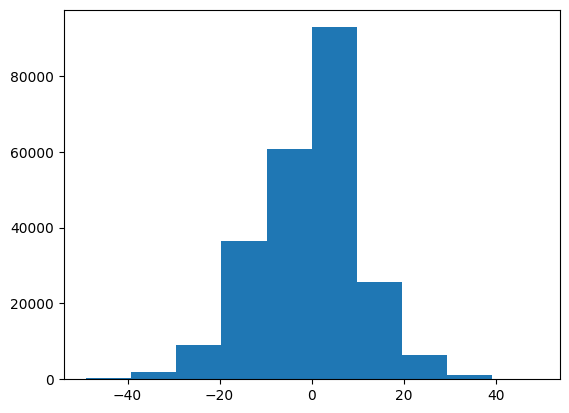

In [13]:
plt.hist(df[['score_differential']])
print(df.score_differential.isna().sum())

In [14]:
def score_diff_possession(row): 
    diff = row.score_differential
    if diff > 7: 
        return 2
    elif diff > 0 and diff <= 7: 
        return 1
    elif diff == 0: 
        return 0
    elif diff < 0 and diff >= -7: 
        return -1
    elif diff < -7: 
        return -2
    else:
        return None

df['poss_differential'] = df.apply(score_diff_possession, axis=1)
# plt.hist(df.poss_differential)

In [15]:
operson = np.array(df['offense_personnel'])

num_rb = []
num_te = []
num_wr = []

def personnel (formation):
    """Finding the number of RB's, TE's, WR's in each formation
    """
    for i in range(len(formation)):
        # takes the personnel and saves it as 'form'
        form = formation[i]
        try:
            rbloc = form.find('RB')-2
            num_rb.append(int(form[rbloc]))
        except: 
            num_rb.append(int(0))
        try:
            teloc = form.find('TE')-2
            num_te.append(int(form[teloc]))
        except: 
            num_te.append(int(0))
        try:
            wrloc = form.find('WR')-2
            num_wr.append(int(form[wrloc]))
        except: 
            num_wr.append(int(0))
            
personnel(operson)

# appending the new columns to the df
df['num_rb'] = num_rb
df['num_te'] = num_te
df['num_wr'] = num_wr

# get dummy for down
dummy = pd.get_dummies(df['down'])
dummy.columns = ['firstdown', 'seconddown', 'thirddown', 'fourthdown']
df = pd.concat([df, dummy], axis=1) 
# drop fourthdown to avoid multicollinearity
df = df.drop(columns=['fourthdown'])

# get dummy for offensive team
posteamdummy = pd.get_dummies(df['posteam'])
posteamdummy.columns = ['oARI', 'oATL', 'oBAL', 'oBUF', 'oCAR', 'oCHI', 'oCIN', 'oCLE', 'oDAL', 
                        'oDEN','oDET', 'oGB', 'oHOU', 'oIND', 'oJAX', 'oKC', 'oLA', 'oLAC', 'oLV', 
                        'oMIA', 'oMIN','oNE', 'oNO', 'oNYG', 'oNYJ', 'oPHI', 'oPIT', 'oSEA', 'oSF', 
                        'oTB', 'oTEN', 'oWAS']
df = pd.concat([df, posteamdummy], axis=1) 
# drop oWAS to avoid multicollinearity
df = df.drop(columns=['oWAS'])

# get dummy for defensive team
defteamdummy = pd.get_dummies(df['defteam'])
defteamdummy.columns = ['dARI', 'dATL', 'dBAL', 'dBUF', 'dCAR', 'dCHI', 'dCIN', 'dCLE', 'dDAL', 
                        'dDEN','dDET', 'dGB', 'dHOU', 'dIND', 'dJAX', 'dKC', 'dLA', 'dLAC', 'dLV', 
                        'dMIA', 'dMIN','dNE', 'dNO', 'dNYG', 'dNYJ', 'dPHI', 'dPIT', 'dSEA', 'dSF', 
                        'dTB', 'dTEN', 'dWAS']
df = pd.concat([df, defteamdummy], axis=1) 
# drop dWAS to avoid multicollinearity
df = df.drop(columns=['dWAS'])

# get dummy for each season
# it looks like 2016 is the start of when they tracked personnel
seasondummy = pd.get_dummies(df['season'])
seasondummy.columns = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']
df = pd.concat([df, seasondummy], axis=1) 
# drop 2022 to avoid multicollinearity
df = df.drop(columns=['2022'])

df.head()

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,dSEA,dSF,dTB,dTEN,2016,2017,2018,2019,2020,2021
290679,58.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,0,0,0,0,1,0,0,0,0,0
290680,85.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,0,0,0,0,1,0,0,0,0,0
290681,109.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,0,0,0,0,1,0,0,0,0,0
290682,130.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,0,0,0,0,1,0,0,0,0,0
290683,154.0,2016_01_BUF_BAL,2016091101,BAL,BUF,REG,1,BAL,home,BUF,...,0,0,0,0,1,0,0,0,0,0


In [16]:
df['poss_differential_2'] = df['poss_differential'].map(lambda p: 1 if p == 2 else 0)
df['poss_differential_1'] = df['poss_differential'].map(lambda p: 1 if p == 1 else 0)
df['poss_differential_0'] = df['poss_differential'].map(lambda p: 1 if p == 0 else 0)
df['poss_differential_-1']= df['poss_differential'].map(lambda p: 1 if p == -1 else 0)
df['poss_differential_-2']= df['poss_differential'].map(lambda p: 1 if p == -2 else 0)

In [17]:
df['first_down_flag'] = df['down'].map(lambda p: 1 if p == 1 else 0)
df['second_down_flag']= df['down'].map(lambda p: 1 if p == 2 else 0)
df['third_down_flag'] = df['down'].map(lambda p: 1 if p == 3 else 0)
df['forth_down_flag'] = df['down'].map(lambda p: 1 if p == 4 else 0)
df = df.copy()

/tmp/ipykernel_1076/4021612049.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['third_down_flag'] = df['down'].map(lambda p: 1 if p == 3 else 0)
/tmp/ipykernel_1076/4021612049.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['forth_down_flag'] = df['down'].map(lambda p: 1 if p == 4 else 0)


In [18]:
def clock_binned(row): 
    if row.play_clock == None: 
        return None
    diff = int(row.play_clock)
    if diff > 20: 
        return 'Greater_than_20 sec'
    elif diff >= 11 and diff <= 20: 
        return 'Between 11 and 20 sec'
    elif diff == 0: 
        return 'clock run-out'
    elif diff >= 5 and diff <= 10: 
        return 'Between 5 and 10 sec'
    elif diff > 0 and diff <= 5 : 
        return 'Between 0 and 5'
    else:
        return None

#applyig on the data set    
df['Play_clock_categorized'] = df.apply(clock_binned, axis=1)

#Creating binary columns for Play_clock_categorized

df['Play_clock_Greater_than_20'] = df['Play_clock_categorized'].map(lambda p: 1 if p == 'Greater_than_20 sec' else 0)
df['Play_clock_Between_11_and_20'] = df['Play_clock_categorized'].map(lambda p: 1 if p == 'Between 11 and 20 sec' else 0)
df['Play_clock_equal_0'] = df['Play_clock_categorized'].map(lambda p: 1 if p == 'clock run-out' else 0)
df['Play_clock_Between_5_and_10'] = df['Play_clock_categorized'].map(lambda p: 1 if p == 'Between 5 and 10 sec' else 0)
df['Play_clock_errors'] = df['Play_clock_categorized'].map(lambda p: 1 if p == None else 0)

In [19]:
temp_df = df[['posteam']]
temp_df = pd.get_dummies(temp_df['posteam'], prefix='pos')
df = pd.concat([df, temp_df], axis=1)

In [20]:
temp_df = df[['defteam']]
temp_df= pd.get_dummies(temp_df['defteam'], prefix='def')
df = pd.concat([df, temp_df], axis=1)

In [21]:
temp_df = df[['season']]
temp_df= pd.get_dummies(temp_df['season'])
df = pd.concat([df, temp_df], axis=1)

In [22]:
# Creating more detailed pass & run categories

def Play_type_detailed(s):
    if s['play_type'] == 'pass' and s['pass_location'] != None and s['pass_length'] != None: 
        return 'PASS' + '_' + str(s['pass_location']).upper() + '_' + str(s['pass_length']).upper()
    elif s['play_type'] == 'run' and s['run_location'] == 'middle': 
        return 'RUSH' + '_' + str(s['run_location']).upper()
    elif s['play_type'] == 'run' and s['run_location'] != None and s['run_gap'] != None: 
        return 'RUSH' + '_' + str(s['run_location']).upper()+ '_' + str(s['run_gap']).upper()
    else:
        return 'OTHER'

df['Play_type_detailed'] = df.apply(Play_type_detailed, axis=1)
df = df[~(df['Play_type_detailed'] == 'OTHER')]    
    

playtypedummy = pd.get_dummies(df['Play_type_detailed'])
playtypedummy.columns = ['PASS_LEFT_DEEP', 'PASS_LEFT_SHORT', 'PASS_MIDDLE_DEEP',
                        'PASS_MIDDLE_SHORT', 'PASS_RIGHT_DEEP', 'PASS_RIGHT_SHORT',
                        'RUSH_LEFT_END', 'RUSH_LEFT_GUARD', 'RUSH_LEFT_TACKLE', 'RUSH_MIDDLE', 
                        'RUSH_RIGHT_END', 'RUSH_RIGHT_GUARD', 'RUSH_RIGHT_TACKLE']
df = pd.concat([df, playtypedummy], axis=1) 
# drop RUSH_RIGHT_TACKLE to avoid multicollinearity
# df = df.drop(columns=['RUSH_RIGHT_TACKLE'])

In [23]:
print(df.Play_type_detailed.unique())

['RUSH_RIGHT_END' 'PASS_RIGHT_SHORT' 'RUSH_LEFT_GUARD' 'RUSH_RIGHT_TACKLE'
 'PASS_MIDDLE_SHORT' 'PASS_LEFT_SHORT' 'PASS_MIDDLE_DEEP' 'PASS_LEFT_DEEP'
 'PASS_RIGHT_DEEP' 'RUSH_RIGHT_GUARD' 'RUSH_MIDDLE' 'RUSH_LEFT_TACKLE'
 'RUSH_LEFT_END']


In [24]:
temp_df = df[['Play_type_detailed']]
temp_df= pd.get_dummies(temp_df['Play_type_detailed'], prefix='PTDetailed')
df = pd.concat([df, temp_df], axis=1)

In [25]:
df['PTDetailed_RUSH_MIDDLE_END'] = df.loc[:, 'RUSH_MIDDLE']

# Create Bandit

In [42]:
class BaselineContextualBandit: 
    def __init__(self, arms, e, yg_model, yg_features, fd_model, fd_features, td_model, td_features): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0
        self.yg_model = yg_model
        self.yg_features = yg_features
        self.fd_model = fd_model
        self.fd_features = fd_features
        self.td_model = td_model
        self.td_features = td_features
        
    def get_defaults(self, red_zone, down, yds_to_go): 
            
            yards_gained = -1
            first_down = -1
            touchdown = -1
            
            if red_zone == 0: 

                if down == 1 and (yds_to_go == 'long' or yds_to_go == '10'): 
                    yards_gained = 0.9
                    first_down = 0.1
                    touchdown = 0
                elif down == 1 and yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 2 and yds_to_go == 'long': 
                    yards_gained = 0.8
                    first_down = 0.2
                    touchdown = 0
                elif down == 2 and yds_to_go == '10': 
                    yards_gained = 0.75
                    first_down = 0.25
                    touchdown = 0
                elif down == 2 and yds_to_go == '5': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == 'long': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == '10': 
                    yards_gained = 0.1
                    first_down = 0.9
                    touchdown = 0
                elif down == 3 and yds_to_go == '5': 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
                elif down == 4 : 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
            
            elif red_zone == 1: 
                
                if yds_to_go == 'long' or yds_to_go == '10': 
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
                elif yds_to_go == '5':
                    yards_gained = 0
                    first_down = 0
                    touchdown = 1
    
            return (yards_gained, first_down, touchdown)
    
    def get_reward_weights(self, quarter, down, yds_to_go, red_zone, poss_diff): 
        reward_weights = {}
        
        yards_gained = -1
        first_down = -1
        touchdown = -1
        
        if poss_diff == 2 and quarter == 1:
            
            if red_zone == 0 and down == 3 and yds_to_go == 10: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            
            elif red_zone == 1: 
                if yds_to_go == '10' or yds_to_go == 'long': 
                    yards_gained = 0.75
                    first_down = 0
                    touchdown = 0.25
                elif yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -1 and quarter == 1: 
            if down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -2 and quarter == 1: 
            if down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and (quarter == 2 or quarter == 3):
            if down == 3 and yds_to_go == '10' and red_zone == 0:
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.75
                first_down = 0
                touchdown = 0.25
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0:
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10': 
                yards_gained = 0.25
                first_down = 0
                touchdown = 0.75
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and quarter == 4: 
            if down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 1 and quarter == 4: 
            if red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and quarter == 4: 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.25
                first_down = 0.25
                touchdown = 0.75
            else:
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and quarter == 4: 
            if down == 1 and (yds_to_go == '10' or yds_to_go == 'long') and red_zone == 0: 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 0
                first_down = 0
                touchdown = 1
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        if (poss_diff == -1 or poss_diff == -2) and quarter == 4: 
            clock_stopped = 1
            clock_not_stopped = -1
        elif (poss_diff == 1 or poss_diff == 2) and quarter == 4: 
            clock_stopped = -1
            clock_not_stopped = 1
        else:
            clock_stopped = 0
            clock_not_stopped = 0
    
        reward_weights['yards_gained'] = yards_gained
        reward_weights['first_down'] = first_down
        reward_weights['touchdown'] = touchdown
        reward_weights['clock_stopped'] = clock_stopped
        reward_weights['clock_not_stopped'] = clock_not_stopped
        return reward_weights
    
    def pull(self, context, row, weights):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context, row, weights)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context, row, weights):
        '''
        Find expected reward for chosen arm in context
        '''
        # yds_gained = np.random.normal(loc=6.0, scale = 8.6)
        # touchdown_pct = np.random.normal(loc=0.04, scale = 0.20)
        # first_down_pct = np.random.normal(loc=0.31, scale = 0.46)
    
        
        if arm == 'PASS_RIGHT_SHORT':
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 1
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 1
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_LEFT_END':
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 1
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 1
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_RIGHT_END': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 1
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 1
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'PASS_LEFT_SHORT': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 1
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 1
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'PASS_MIDDLE_SHORT': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 1
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 1
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'PASS_RIGHT_DEEP': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 1
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 1
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'PASS_LEFT_DEEP': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 1
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 1
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_MIDDLE': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 1
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 1
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'PASS_MIDDLE_DEEP': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 1
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 1
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_LEFT_GUARD':
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 1
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 1
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_RIGHT_TACKLE': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 1
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 1
        elif arm == 'RUSH_RIGHT_GUARD': 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 0
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 1
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 0
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 1
            row['RUSH_RIGHT_TACKLE'] = 0
        elif arm == 'RUSH_LEFT_TACKLE' : 
            row['PTDetailed_PASS_LEFT_DEEP'] = 0
            row['PTDetailed_PASS_LEFT_SHORT'] = 0
            row['PTDetailed_PASS_MIDDLE_DEEP'] = 0
            row['PTDetailed_PASS_MIDDLE_SHORT'] = 0
            row['PTDetailed_PASS_RIGHT_DEEP'] = 0
            row['PTDetailed_PASS_RIGHT_SHORT'] = 0
            row['PTDetailed_RUSH_LEFT_END'] = 0
            row['PTDetailed_RUSH_LEFT_GUARD'] = 0
            row['PTDetailed_RUSH_LEFT_TACKLE'] = 1
            row['PTDetailed_RUSH_MIDDLE_END'] = 0
            row['PTDetailed_RUSH_RIGHT_END'] = 0
            row['PTDetailed_RUSH_RIGHT_GUARD'] = 0
            row['PTDetailed_RUSH_RIGHT_TACKLE'] = 0
            row['PASS_LEFT_DEEP'] = 0
            row['PASS_LEFT_SHORT'] = 0
            row['PASS_MIDDLE_DEEP'] = 0
            row['PASS_MIDDLE_SHORT'] = 0
            row['PASS_RIGHT_DEEP'] = 0
            row['PASS_RIGHT_SHORT'] = 0
            row['RUSH_LEFT_END'] = 0
            row['RUSH_LEFT_GUARD'] = 0
            row['RUSH_LEFT_TACKLE'] = 1
            row['RUSH_MIDDLE'] = 0
            row['RUSH_RIGHT_END'] = 0
            row['RUSH_RIGHT_GUARD'] = 0
            row['RUSH_RIGHT_TACKLE'] = 0
        else: 
            print("Unrecognized arm: " + str(arm))
            
        
        yds_gained = self.yg_model.predict(row[self.yg_features].to_numpy().reshape(1, -1))
        first_down_pct = self.fd_model.predict(row[self.fd_features].to_numpy().reshape(1, -1))
        touch_down_pct = self.td_model.predict(row[self.td_features].to_numpy().reshape(1, -1))

        if arm[0:4] == 'RUSH': 
            clock_will_stop = 0
            clock_will_not_stop = 1
        else:
            clock_will_stop = 1
            clock_will_not_stop = 0
        
        
        if first_down_pct > 0: 
            first_down = 1
        else: 
            first_down = 0
        
        if touch_down_pct > 0: 
            touch_down = 1
        else: 
            touch_down = 0
            
        
        yds_gained_weight = weights['yards_gained']
        first_down_weight = weights['first_down']
        touchdown_weight = weights['touchdown']
        clock_stopped_weight = weights['clock_stopped']
        clock_not_stopped_weight = weights['clock_not_stopped']
        
        return (yds_gained_weight * (yds_gained / 100)) + (touchdown_weight * touch_down) + (first_down_weight * first_down) + (clock_will_stop * clock_stopped_weight) + (clock_will_not_stop * clock_not_stopped_weight)
    
    def train(self, df): 
        
        full_mark = int(len(df))
        three_quarter_mark = int(len(df) * 0.75)
        half_mark = int(len(df) * 0.5)
        quarter_mark = int(len(df) * 0.25)
        counter = 0
        #Iterate over dataframe
        for index, row in df.iterrows():
            counter += 1
            
            if counter == quarter_mark:
                print("Training 25% done...")
            elif counter == half_mark:
                print("Training 50% done...")
            elif counter == three_quarter_mark:
                print("Training 75% done...")
            elif counter == full_mark:
                print("Training 100% done...")
            
            #Pull context
            context_key, weights = self.get_context_key(row)
            
            #Initialize rewards if this is new context
            if context_key not in self.context_rewards.keys(): 
                self.context_rewards[context_key] = np.zeros(len(self.arms))
                self.context_n[context_key] = np.zeros(len(self.arms))
            
            #Update rewards
            self.pull(context_key, row, weights)

    def predict(self, df, evaluate=True, generate_output = False): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        unseen_context = 0
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 

            #Pull context
            context_key = self.get_context_key(row, test=1)[0]
            
            #Pull relevant rewards vector
            if context_key in self.context_rewards.keys(): 
                rewards = self.context_rewards[context_key]
            else: 
                rewards = list(np.array([1])) + list(np.zeros(len(self.arms) - 1))
                # print(context_key)
                unseen_context += 1

            
            idx_sorted = sorted(range(len(rewards)), key=lambda i: rewards[i])
            
            if not generate_output: 
                #find highest rewards
                max_idx = idx_sorted[-1]
                #Select associated arm with highest rewards
                arm = self.arms[max_idx] 
                #Add to predictions
                predictions.append(arm)
                
            else :
                idx = idx_sorted[-3:]
                arms = []
                for i in idx: 
                    arms.append(self.arms[i])
                predictions.append(pd.Series(arms))
                
            if evaluate: 
                if row.Play_type_detailed == arm:
                    self.match_count += 1
                    if row.success: 
                        self.success_count += 1
 

        print(unseen_context)
        return predictions

    def get_context_key(self, row, test = 0): 
        yds_to_go = row.ydstogo_binned
        red_zone = row.red_zone
        poss_diff = row.poss_differential
        down = row.down
        quarter = row.qtr
        team = row.defteam
        
        if red_zone: 
            down = 0.0
        if quarter == 3.0: 
            quarter = 2.0
        
        context_key = str(quarter) + "_" + str(down) + "_" + str(yds_to_go) + "_" + str(poss_diff) + "_" + str(red_zone) + "_" + str(team)
        
        if not test: 
            weights = self.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff) 
        else: 
            weights = None
        
        return context_key, weights

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [27]:
def define_successful_play(row): 
    if row.yards_gained > 3 or row.touchdown or row.first_down:
        return 1
    else:
        return 0
    
df['success'] = df.apply(define_successful_play, axis=1)

# Download Models

In [28]:
from huggingface_hub import notebook_login
from huggingface_hub import hf_hub_download
notebook_login()

In [29]:
#Yards Gained Model
model_location = hf_hub_download(repo_id="ic-hua/yards-gained-model", filename="yards-gained-clf.joblib")
download_yards_gained_model = load(model_location) 

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
yg_features = ['yardline_100', 'firstdown', 'seconddown', 'thirddown', 
            'ydstogo', 'game_seconds_remaining', 'score_differential', 
            'num_rb', 'num_te', 'num_wr','posteam_timeouts_remaining', 'defteam_timeouts_remaining',
            'oARI', 'oATL', 'oBAL', 'oBUF', 'oCAR', 'oCHI', 'oCIN', 'oCLE', 'oDAL', 
            'oDEN','oDET', 'oGB', 'oHOU', 'oIND', 'oJAX', 'oKC', 'oLA', 'oLAC', 'oLV', 
            'oMIA', 'oMIN','oNE', 'oNO', 'oNYG', 'oNYJ', 'oPHI', 'oPIT', 'oSEA', 'oSF', 
            'oTB', 'oTEN',
            'dARI', 'dATL', 'dBAL', 'dBUF', 'dCAR', 'dCHI', 'dCIN', 'dCLE', 'dDAL', 
            'dDEN','dDET', 'dGB', 'dHOU', 'dIND', 'dJAX', 'dKC', 'dLA', 'dLAC', 'dLV', 
            'dMIA', 'dMIN','dNE', 'dNO', 'dNYG', 'dNYJ', 'dPHI', 'dPIT', 'dSEA', 'dSF', 
            'dTB', 'dTEN',
            '2016', '2017', '2018', '2019', '2020', '2021',
            'PASS_LEFT_DEEP', 'PASS_LEFT_SHORT', 'PASS_MIDDLE_DEEP',
            'PASS_MIDDLE_SHORT', 'PASS_RIGHT_DEEP', 'PASS_RIGHT_SHORT',
            'RUSH_LEFT_END', 'RUSH_LEFT_GUARD', 'RUSH_LEFT_TACKLE', 'RUSH_MIDDLE', 
            'RUSH_RIGHT_END', 'RUSH_RIGHT_GUARD']

predictions = download_yards_gained_model.predict(df[yg_features].to_numpy())

In [31]:
print(predictions)

[6.5218172  6.29414813 5.13983441 ... 3.50197728 2.90106165 7.23335572]


In [32]:
fd_model_location = hf_hub_download(repo_id="mchawla33/regressor_first_down", filename="regressor_first_down.joblib")
download_first_down_model = load(fd_model_location) 

In [33]:
fd_features = ['ydstogo', 'yardline_100', 'season', 'game_seconds_remaining', 'score_differential', 
               'poss_differential_2', 'poss_differential_1', 'poss_differential_0', 'poss_differential_-1', 'poss_differential_-2', 
  'first_down_flag', 'second_down_flag', 'third_down_flag', 'forth_down_flag', 
  'Play_clock_errors', 'Play_clock_equal_0', 'Play_clock_Between_5_and_10', 'Play_clock_Between_11_and_20', 'Play_clock_Greater_than_20',
  'off_rb_count', 'off_te_count', 'off_wr_count', 'off_ol_count', 'off_dl_count', 'off_db_count',
  'def_dl_count', 'def_db_count', 'def_lb_count', 'def_rb_count', 'def_wr_count', 'def_ol_count',
               # 'defenders_in_box', 'n_offense', 'n_defense',
 'pos_ARI', 'pos_ATL', 'pos_BAL', 'pos_BUF', 'pos_CAR', 'pos_CHI', 'pos_CIN', 'pos_CLE', 'pos_DAL', 'pos_DEN', 'pos_DET', 'pos_GB',
 'pos_HOU', 'pos_IND', 'pos_JAX', 'pos_KC', 'pos_LA', 'pos_LAC', 'pos_LV', 'pos_MIA', 'pos_MIN', 'pos_NE', 'pos_NO', 'pos_NYG', 'pos_NYJ',
 'pos_PHI', 'pos_PIT', 'pos_SEA', 'pos_SF', 'pos_TB', 'pos_TEN', 'pos_WAS',
 'def_ARI', 'def_ATL', 'def_BAL', 'def_BUF', 'def_CAR', 'def_CHI', 'def_CIN', 'def_CLE', 'def_DAL', 'def_DEN', 'def_DET', 'def_GB',
 'def_HOU', 'def_IND', 'def_JAX', 'def_KC', 'def_LA', 'def_LAC', 'def_LV', 'def_MIA', 'def_MIN', 'def_NE', 'def_NO', 'def_NYG', 'def_NYJ',
 'def_PHI', 'def_PIT', 'def_SEA', 'def_SF', 'def_TB', 'def_TEN', 'def_WAS',  2016, 2017, 2018, 2019, 2020, 2021,
  'PTDetailed_PASS_LEFT_DEEP', 'PTDetailed_PASS_LEFT_SHORT', 'PTDetailed_PASS_MIDDLE_DEEP', 'PTDetailed_PASS_MIDDLE_SHORT', 'PTDetailed_PASS_RIGHT_DEEP',
 'PTDetailed_PASS_RIGHT_SHORT', 'PTDetailed_RUSH_LEFT_END', 'PTDetailed_RUSH_LEFT_GUARD', 'PTDetailed_RUSH_LEFT_TACKLE', 'PTDetailed_RUSH_MIDDLE_END',
 'PTDetailed_RUSH_RIGHT_END', 'PTDetailed_RUSH_RIGHT_GUARD', 'PTDetailed_RUSH_RIGHT_TACKLE']

test_frame = df[fd_features].sample(100)
predictions = download_first_down_model.predict(test_frame.to_numpy())

In [34]:
td_model_location = hf_hub_download(repo_id="mchawla33/regressor_Touch_Down", filename="regressor_Touch_Down.joblib")
download_touch_down_model = load(td_model_location) 

In [35]:
td_features = ['ydstogo', 'yardline_100', 'season', 'game_seconds_remaining', 'score_differential', 
               'poss_differential_2', 'poss_differential_1', 'poss_differential_0', 'poss_differential_-1', 'poss_differential_-2', 
  'first_down_flag', 'second_down_flag', 'third_down_flag', 'forth_down_flag', 
  'Play_clock_errors', 'Play_clock_equal_0', 'Play_clock_Between_5_and_10', 'Play_clock_Between_11_and_20', 'Play_clock_Greater_than_20',
  'off_rb_count', 'off_te_count', 'off_wr_count', 'off_ol_count', 'off_dl_count', 'off_db_count',
  'def_dl_count', 'def_db_count', 'def_lb_count', 'def_rb_count', 'def_wr_count', 'def_ol_count',
               # 'defenders_in_box', 'n_offense', 'n_defense',
 'pos_ARI', 'pos_ATL', 'pos_BAL', 'pos_BUF', 'pos_CAR', 'pos_CHI', 'pos_CIN', 'pos_CLE', 'pos_DAL', 'pos_DEN', 'pos_DET', 'pos_GB',
 'pos_HOU', 'pos_IND', 'pos_JAX', 'pos_KC', 'pos_LA', 'pos_LAC', 'pos_LV', 'pos_MIA', 'pos_MIN', 'pos_NE', 'pos_NO', 'pos_NYG', 'pos_NYJ',
 'pos_PHI', 'pos_PIT', 'pos_SEA', 'pos_SF', 'pos_TB', 'pos_TEN', 'pos_WAS',
 'def_ARI', 'def_ATL', 'def_BAL', 'def_BUF', 'def_CAR', 'def_CHI', 'def_CIN', 'def_CLE', 'def_DAL', 'def_DEN', 'def_DET', 'def_GB',
 'def_HOU', 'def_IND', 'def_JAX', 'def_KC', 'def_LA', 'def_LAC', 'def_LV', 'def_MIA', 'def_MIN', 'def_NE', 'def_NO', 'def_NYG', 'def_NYJ',
 'def_PHI', 'def_PIT', 'def_SEA', 'def_SF', 'def_TB', 'def_TEN', 'def_WAS',  2016, 2017, 2018, 2019, 2020, 2021,
  'PTDetailed_PASS_LEFT_DEEP', 'PTDetailed_PASS_LEFT_SHORT', 'PTDetailed_PASS_MIDDLE_DEEP', 'PTDetailed_PASS_MIDDLE_SHORT', 'PTDetailed_PASS_RIGHT_DEEP',
 'PTDetailed_PASS_RIGHT_SHORT', 'PTDetailed_RUSH_LEFT_END', 'PTDetailed_RUSH_LEFT_GUARD', 'PTDetailed_RUSH_LEFT_TACKLE', 'PTDetailed_RUSH_MIDDLE_END',
 'PTDetailed_RUSH_RIGHT_END', 'PTDetailed_RUSH_RIGHT_GUARD', 'PTDetailed_RUSH_RIGHT_TACKLE']

test_frame = df[td_features].sample(100)
predictions = download_touch_down_model.predict(test_frame.to_numpy())

In [36]:
train_df, test_df = train_test_split(df, test_size=.20, random_state = 123)

In [43]:
possible_plays = list(df.Play_type_detailed.unique())

bandit = BaselineContextualBandit(possible_plays, 0.1, download_yards_gained_model, yg_features, download_first_down_model, fd_features, download_touch_down_model, td_features)
bandit.train(train_df)

# print(bandit.context_rewards)
# print("==========")
# print(bandit.context_n)
# print("==========")
print(bandit.mean_reward)

Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
[0.48384891]


In [44]:
predictions = bandit.predict(test_df)

172


In [45]:
print(bandit.get_evaluation_metrics())

(2454, 1344, 0.5476772616136919)


# Cross Validation

In [46]:
folds = 5
prng = np.random.RandomState(123)

states = prng.randint(1, 9000, size=folds)
# states = [states[3]]

counter = 0
replays = []
best_replay = -1
best_bandit = None
best_train_df = None
best_test_df = None
for state in states: 
    counter += 1
    print("Starting Fold " + str(counter) + "...")
    train_df_fold, test_df_fold = train_test_split(df, test_size=.20, random_state = state)
    cur_bandit = BaselineContextualBandit(possible_plays, 0.1, download_yards_gained_model, yg_features, download_first_down_model, fd_features, download_touch_down_model, td_features)
    cur_bandit.train(train_df_fold)
    predictions = cur_bandit.predict(test_df_fold)
    cur_replay = cur_bandit.get_evaluation_metrics()[2]
    replays.append(cur_replay)

    if cur_replay > best_replay: 
        best_replay = cur_replay
        best_bandit = cur_bandit
        best_train_df = train_df_fold
        best_test_df = test_df_fold

print(replays)
print("Best replay value: " + str(best_replay))

Starting Fold 1...
Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
142
Starting Fold 2...
Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
153
Starting Fold 3...
Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
170
Starting Fold 4...
Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
148
Starting Fold 5...
Training 25% done...
Training 50% done...
Training 75% done...
Training 100% done...
153
[0.5522788203753352, 0.5313272877164056, 0.5496774193548387, 0.5405172413793103, 0.540484997944924]
Best replay value: 0.5522788203753352


In [48]:
best_test_df['pred_play'] = best_bandit.predict(best_test_df)
display(best_test_df[['Play_type_detailed', 'pred_play', 'success']])

142


,Play_type_detailed,pred_play,success
493249,PASS_LEFT_DEEP,PASS_LEFT_SHORT,1
396141,PASS_MIDDLE_SHORT,PASS_MIDDLE_DEEP,1
464168,RUSH_RIGHT_GUARD,RUSH_RIGHT_END,0
441605,PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,1
349544,PASS_LEFT_SHORT,PASS_RIGHT_SHORT,1
...,...,...,...
432677,PASS_RIGHT_SHORT,RUSH_MIDDLE,1
376257,PASS_LEFT_SHORT,PASS_LEFT_DEEP,0
354594,PASS_RIGHT_SHORT,RUSH_RIGHT_END,0
564065,PASS_MIDDLE_SHORT,RUSH_RIGHT_END,1


In [49]:
matches = best_test_df[best_test_df.Play_type_detailed == best_test_df.pred_play]
misses = best_test_df[best_test_df.Play_type_detailed != best_test_df.pred_play]
print(len(matches))
print(len(misses))
print(sum(best_test_df.success))

2238
37300
21492


In [50]:
display(matches[['Play_type_detailed', 'pred_play', 'success', 'yards_gained', 'touchdown', 'first_down', 'series_result', 'ydstogo', 'down', 'qb_kneel']])
print(sum(best_test_df.success) / len(best_test_df))

,Play_type_detailed,pred_play,success,yards_gained,touchdown,first_down,series_result,ydstogo,down,qb_kneel
307266,RUSH_MIDDLE,RUSH_MIDDLE,0,1.0,0.0,0.0,Punt,3.0,3.0,0.0
409273,PASS_MIDDLE_DEEP,PASS_MIDDLE_DEEP,0,0.0,0.0,0.0,First down,5.0,2.0,0.0
398870,RUSH_RIGHT_END,RUSH_RIGHT_END,1,8.0,0.0,0.0,First down,9.0,2.0,0.0
313912,PASS_LEFT_SHORT,PASS_LEFT_SHORT,1,4.0,0.0,0.0,Punt,13.0,2.0,0.0
395149,RUSH_RIGHT_GUARD,RUSH_RIGHT_GUARD,1,4.0,0.0,0.0,Punt,6.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
479491,RUSH_MIDDLE,RUSH_MIDDLE,1,3.0,0.0,1.0,First down,1.0,2.0,0.0
508449,PASS_RIGHT_SHORT,PASS_RIGHT_SHORT,0,0.0,0.0,0.0,Punt,8.0,3.0,0.0
326389,RUSH_RIGHT_END,RUSH_RIGHT_END,0,2.0,0.0,0.0,First down,3.0,2.0,0.0
479019,PASS_RIGHT_SHORT,PASS_RIGHT_SHORT,1,20.0,0.0,1.0,First down,9.0,3.0,0.0


0.5435783297081289


In [51]:
best_test_df[['pred_play_1', 'pred_play_2', 'pred_play_3']] = best_bandit.predict(best_test_df, evaluate=False, generate_output=True)
# best_bandit.predict(best_test_df)

142


In [52]:
# field = 'Play_type_detailed'
# for row, i in best_test_df.iterrows(): 
#     print(i.loc[field])

In [53]:
def depthless(row, field): 
    value = row.loc[field]
    
    if value == 'PASS_RIGHT_SHORT' or value == 'PASS_RIGHT_DEEP': 
        return 'PASS_RIGHT' 
    elif value == 'PASS_LEFT_SHORT' or value == 'PASS_LEFT_DEEP': 
        return 'PASS_LEFT'
    elif value == 'PASS_MIDDLE_SHORT' or value == 'PASS_MIDDLE_DEEP': 
        return 'PASS_MIDDLE' 
    elif value == 'RUSH_RIGHT_END' or value =='RUSH_RIGHT_GUARD' or value == 'RUSH_RIGHT_TACKLE': 
        return 'RUSH_RIGHT'
    elif value == 'RUSH_LEFT_END' or value == 'RUSH_LEFT_GUARD' or value == 'RUSH_LEFT_TACKLE':
        return 'RUSH_LEFT'
    elif value == 'RUSH_MIDDLE':
        return 'RUSH_MIDDLE'
    else:
        print(value)

best_test_df['Play_type_detailed_depthless'] = best_test_df.apply(lambda x: depthless(x, 'Play_type_detailed'), axis=1 )
best_test_df['pred_play_depthless'] = best_test_df.apply(lambda x: depthless(x, 'pred_play'), axis=1 )
best_test_df['pred_play_1_depthless'] = best_test_df.apply(lambda x: depthless(x, 'pred_play_1'), axis=1 )
best_test_df['pred_play_2_depthless'] = best_test_df.apply(lambda x: depthless(x, 'pred_play_2'), axis=1 )
best_test_df['pred_play_3_depthless'] = best_test_df.apply(lambda x: depthless(x, 'pred_play_3'), axis=1 )

In [54]:
def directionless(row, field): 
    value = row.loc[field]
    
    if value == 'PASS_RIGHT_SHORT' or value == 'PASS_LEFT_SHORT' or value == 'PASS_MIDDLE_SHORT': 
        return 'PASS_SHORT' 
    elif value == 'PASS_RIGHT_DEEP' or value == 'PASS_LEFT_DEEP' or value == 'PASS_MIDDLE_DEEP': 
        return 'PASS_DEEP'
    elif value == 'RUSH_RIGHT_END' or value == 'RUSH_LEFT_END' : 
        return 'RUSH_END'
    elif  value =='RUSH_RIGHT_GUARD' or value == 'RUSH_LEFT_GUARD' :
        return 'RUSH_GUARD'
    elif value == 'RUSH_LEFT_TACKLE' or value == 'RUSH_RIGHT_TACKLE':
        return 'RUSH_TACKLE'
    elif value == 'RUSH_MIDDLE':
        return 'RUSH_MIDDLE'
    else:
        print(value)
        
best_test_df['Play_type_detailed_directionless'] = best_test_df.apply(lambda x: directionless(x, 'Play_type_detailed'), axis=1 )
best_test_df['pred_play_directionless'] = best_test_df.apply(lambda x: directionless(x, 'pred_play'), axis=1 )
best_test_df['pred_play_1_directionless'] = best_test_df.apply(lambda x: directionless(x, 'pred_play_1'), axis=1 )
best_test_df['pred_play_2_directionless'] = best_test_df.apply(lambda x: directionless(x, 'pred_play_2'), axis=1 )
best_test_df['pred_play_3_directionless'] = best_test_df.apply(lambda x: directionless(x, 'pred_play_3'), axis=1 )

In [55]:
display(best_test_df[['Play_type_detailed', 'pred_play', 'pred_play_1', 'pred_play_2', 'pred_play_3', 'success', 'Play_type_detailed_depthless', 'pred_play_depthless', 'pred_play_1_depthless', 'pred_play_2_depthless', 'pred_play_3_depthless', 'Play_type_detailed_directionless', 'pred_play_directionless', 'pred_play_1_directionless', 'pred_play_2_directionless', 'pred_play_3_directionless']])

,Play_type_detailed,pred_play,pred_play_1,pred_play_2,pred_play_3,success,Play_type_detailed_depthless,pred_play_depthless,pred_play_1_depthless,pred_play_2_depthless,pred_play_3_depthless,Play_type_detailed_directionless,pred_play_directionless,pred_play_1_directionless,pred_play_2_directionless,pred_play_3_directionless
493249,PASS_LEFT_DEEP,PASS_LEFT_SHORT,PASS_RIGHT_DEEP,PASS_RIGHT_SHORT,PASS_LEFT_SHORT,1,PASS_LEFT,PASS_LEFT,PASS_RIGHT,PASS_RIGHT,PASS_LEFT,PASS_DEEP,PASS_SHORT,PASS_DEEP,PASS_SHORT,PASS_SHORT
396141,PASS_MIDDLE_SHORT,PASS_MIDDLE_DEEP,RUSH_RIGHT_END,PASS_MIDDLE_SHORT,PASS_MIDDLE_DEEP,1,PASS_MIDDLE,PASS_MIDDLE,RUSH_RIGHT,PASS_MIDDLE,PASS_MIDDLE,PASS_SHORT,PASS_DEEP,RUSH_END,PASS_SHORT,PASS_DEEP
464168,RUSH_RIGHT_GUARD,RUSH_RIGHT_END,RUSH_LEFT_TACKLE,RUSH_LEFT_END,RUSH_RIGHT_END,0,RUSH_RIGHT,RUSH_RIGHT,RUSH_LEFT,RUSH_LEFT,RUSH_RIGHT,RUSH_GUARD,RUSH_END,RUSH_TACKLE,RUSH_END,RUSH_END
441605,PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP,PASS_RIGHT_DEEP,PASS_MIDDLE_DEEP,1,PASS_RIGHT,PASS_MIDDLE,PASS_LEFT,PASS_RIGHT,PASS_MIDDLE,PASS_SHORT,PASS_DEEP,PASS_DEEP,PASS_DEEP,PASS_DEEP
349544,PASS_LEFT_SHORT,PASS_RIGHT_SHORT,RUSH_LEFT_END,RUSH_RIGHT_END,PASS_RIGHT_SHORT,1,PASS_LEFT,PASS_RIGHT,RUSH_LEFT,RUSH_RIGHT,PASS_RIGHT,PASS_SHORT,PASS_SHORT,RUSH_END,RUSH_END,PASS_SHORT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432677,PASS_RIGHT_SHORT,RUSH_MIDDLE,RUSH_RIGHT_TACKLE,RUSH_RIGHT_GUARD,RUSH_MIDDLE,1,PASS_RIGHT,RUSH_MIDDLE,RUSH_RIGHT,RUSH_RIGHT,RUSH_MIDDLE,PASS_SHORT,RUSH_MIDDLE,RUSH_TACKLE,RUSH_GUARD,RUSH_MIDDLE
376257,PASS_LEFT_SHORT,PASS_LEFT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,0,PASS_LEFT,PASS_LEFT,PASS_MIDDLE,PASS_RIGHT,PASS_LEFT,PASS_SHORT,PASS_DEEP,PASS_SHORT,PASS_DEEP,PASS_DEEP
354594,PASS_RIGHT_SHORT,RUSH_RIGHT_END,RUSH_LEFT_TACKLE,RUSH_LEFT_END,RUSH_RIGHT_END,0,PASS_RIGHT,RUSH_RIGHT,RUSH_LEFT,RUSH_LEFT,RUSH_RIGHT,PASS_SHORT,RUSH_END,RUSH_TACKLE,RUSH_END,RUSH_END
564065,PASS_MIDDLE_SHORT,RUSH_RIGHT_END,RUSH_LEFT_TACKLE,RUSH_LEFT_END,RUSH_RIGHT_END,1,PASS_MIDDLE,RUSH_RIGHT,RUSH_LEFT,RUSH_LEFT,RUSH_RIGHT,PASS_SHORT,RUSH_END,RUSH_TACKLE,RUSH_END,RUSH_END


In [56]:
replay = len(best_test_df[(best_test_df.Play_type_detailed == best_test_df.pred_play) & (best_test_df.success == 1)]) / (len(best_test_df[(best_test_df.Play_type_detailed == best_test_df.pred_play)]))
replay_top_3 = len(best_test_df[((best_test_df.Play_type_detailed == best_test_df.pred_play_1) | (best_test_df.Play_type_detailed == best_test_df.pred_play_2) | (best_test_df.Play_type_detailed == best_test_df.pred_play_3)) & (best_test_df.success == 1)]) / len(best_test_df[((best_test_df.Play_type_detailed == best_test_df.pred_play_1) | (best_test_df.Play_type_detailed == best_test_df.pred_play_2) | (best_test_df.Play_type_detailed == best_test_df.pred_play_3))])
replay_depthless = len(best_test_df[((best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_1_depthless) | (best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_2_depthless) | (best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_3_depthless)) & (best_test_df.success == 1)]) / len(best_test_df[((best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_1_depthless) | (best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_2_depthless) | (best_test_df.Play_type_detailed_depthless == best_test_df.pred_play_3_depthless))])
replay_directionless = len(best_test_df[((best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_1_directionless) | (best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_2_directionless) | (best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_3_directionless)) & (best_test_df.success == 1)]) / len(best_test_df[((best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_1_directionless) | (best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_2_directionless) | (best_test_df.Play_type_detailed_directionless == best_test_df.pred_play_3_directionless))])

print("Replay: " + str(replay))
print("Replay Top 3: " + str(replay_top_3))
print("Replay Depthless: " + str(replay_depthless))
print("Replay Directionless: " + str(replay_directionless))

Replay: 0.5522788203753352
Replay Top 3: 0.5458328233998286
Replay Depthless: 0.5540369817388309
Replay Directionless: 0.5578960335057896


In [83]:
!pip install seaborn

     |████████████████████████████████| 288 kB 6.1 MB/s eta 0:00:01


<AxesSubplot: xlabel='pred_play_3', ylabel='Play_type_detailed'>

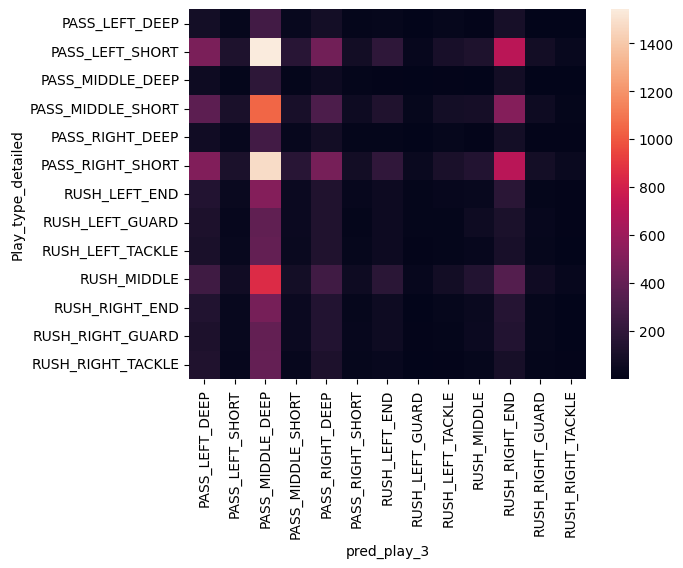

In [89]:
import seaborn as sn
matrix_3 = pd.crosstab(best_test_df[best_test_df.success == 1].Play_type_detailed, best_test_df[best_test_df.success ==1].pred_play_3)
sn.heatmap(matrix_3)

<AxesSubplot: xlabel='pred_play_2', ylabel='Play_type_detailed'>

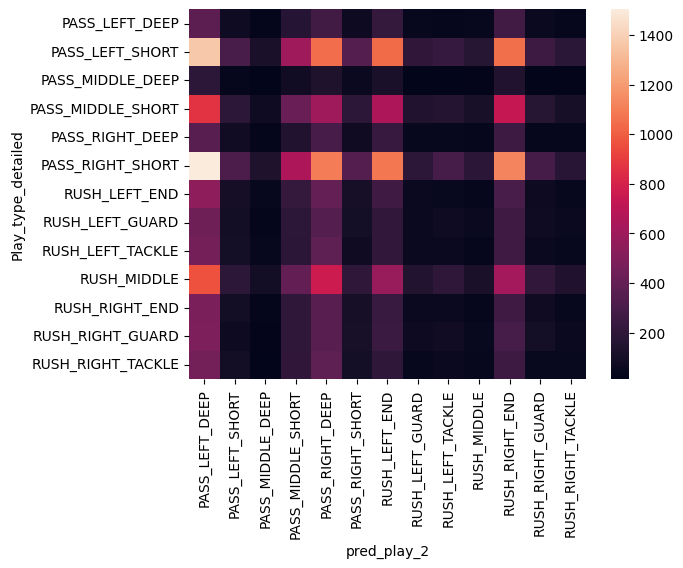

In [90]:
matrix_2 = pd.crosstab(best_test_df.Play_type_detailed, best_test_df.pred_play_2)
sn.heatmap(matrix_2)


<AxesSubplot: xlabel='pred_play_3', ylabel='Play_type_detailed'>

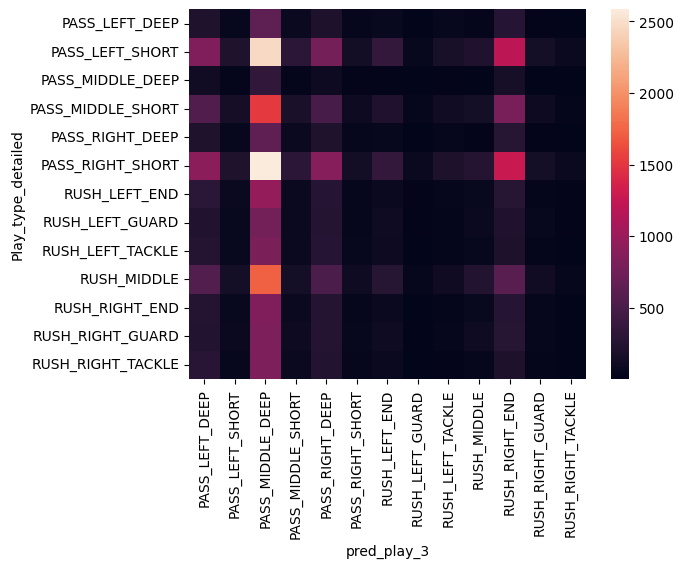

In [91]:
matrix_1 = pd.crosstab(best_test_df.Play_type_detailed, best_test_df.pred_play_1)
sn.heatmap(matrix)

In [70]:
matches_3 = best_test_df[(best_test_df.Play_type_detailed == best_test_df.pred_play_1) | (best_test_df.Play_type_detailed == best_test_df.pred_play_2) | (best_test_df.Play_type_detailed == best_test_df.pred_play_3) ]
# matches_3 = best_test_df[best_test_df.Play_type_detailed == best_test_df.pred_play_3 ]

display(matches_3[['Play_type_detailed', 'pred_play_1', 'pred_play_2', 'pred_play_3', 'success', 'yards_gained', 'touchdown', 'first_down']])
print(matches_3.success.sum() / len(matches_3)) 

,Play_type_detailed,pred_play_1,pred_play_2,pred_play_3,success,yards_gained,touchdown,first_down
351601,PASS_LEFT_SHORT,RUSH_LEFT_END,PASS_LEFT_SHORT,PASS_LEFT_DEEP,0,0.0,0.0,0.0
426863,PASS_MIDDLE_SHORT,PASS_MIDDLE_SHORT,PASS_RIGHT_DEEP,PASS_MIDDLE_DEEP,1,7.0,0.0,0.0
363745,PASS_LEFT_SHORT,PASS_LEFT_SHORT,PASS_RIGHT_DEEP,PASS_MIDDLE_DEEP,1,7.0,0.0,1.0
363612,RUSH_LEFT_END,RUSH_LEFT_END,PASS_RIGHT_SHORT,RUSH_RIGHT_END,0,3.0,0.0,0.0
371806,RUSH_RIGHT_END,PASS_RIGHT_DEEP,RUSH_RIGHT_END,PASS_LEFT_SHORT,1,12.0,0.0,0.0
...,...,...,...,...,...,...,...,...
535676,RUSH_RIGHT_END,RUSH_RIGHT_END,PASS_LEFT_SHORT,PASS_MIDDLE_DEEP,0,0.0,0.0,0.0
432952,PASS_MIDDLE_DEEP,RUSH_RIGHT_END,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,1,38.0,0.0,1.0
580156,RUSH_RIGHT_END,RUSH_LEFT_TACKLE,RUSH_LEFT_END,RUSH_RIGHT_END,1,15.0,0.0,1.0
546798,PASS_LEFT_SHORT,RUSH_RIGHT_END,PASS_RIGHT_SHORT,PASS_LEFT_SHORT,1,8.0,0.0,0.0


0.5601257532093267


In [82]:
misses_3 = best_test_df[(best_test_df.Play_type_detailed != best_test_df.pred_play_1) & (best_test_df.Play_type_detailed != best_test_df.pred_play_2) & (best_test_df.Play_type_detailed != best_test_df.pred_play_3) ]
display(misses_3[['Play_type_detailed', 'pred_play_1', 'pred_play_2', 'pred_play_3', 'success', 'yards_gained', 'touchdown', 'first_down', 'fumble']])

,Play_type_detailed,pred_play_1,pred_play_2,pred_play_3,success,yards_gained,touchdown,first_down,fumble
529456,PASS_RIGHT_SHORT,PASS_LEFT_SHORT,PASS_MIDDLE_SHORT,PASS_RIGHT_DEEP,1,6.0,1.0,1.0,0.0
441487,PASS_RIGHT_SHORT,RUSH_RIGHT_END,PASS_LEFT_DEEP,PASS_RIGHT_DEEP,0,0.0,0.0,0.0,0.0
561425,PASS_MIDDLE_SHORT,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,1,11.0,0.0,1.0,0.0
542169,RUSH_MIDDLE,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,0,1.0,0.0,0.0,0.0
296487,RUSH_MIDDLE,PASS_MIDDLE_SHORT,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,1,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
548617,PASS_RIGHT_SHORT,RUSH_LEFT_END,PASS_LEFT_SHORT,RUSH_RIGHT_END,1,6.0,0.0,0.0,0.0
333744,PASS_MIDDLE_DEEP,RUSH_LEFT_END,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,1,21.0,0.0,1.0,0.0
412311,PASS_RIGHT_SHORT,RUSH_RIGHT_GUARD,RUSH_RIGHT_END,PASS_MIDDLE_DEEP,0,0.0,0.0,0.0,0.0
564558,PASS_MIDDLE_DEEP,RUSH_LEFT_TACKLE,RUSH_LEFT_END,RUSH_RIGHT_END,0,0.0,0.0,0.0,0.0


294.0


In [79]:
pass_middle_short = misses_3[(misses_3.Play_type_detailed == 'PASS_MIDDLE_SHORT') & (misses_3.pred_play_3 == 'PASS_MIDDLE_DEEP')]
pass_right_short = misses_3[(misses_3.Play_type_detailed == 'PASS_RIGHT_SHORT') & (misses_3.pred_play_3 == 'PASS_RIGHT_DEEP')]
pass_left_short = misses_3[(misses_3.Play_type_detailed == 'PASS_LEFT_SHORT') & (misses_3.pred_play_3 == 'PASS_LEFT_DEEP')]

deep_for_short = pd.concat([pass_middle_short, pass_right_short, pass_left_short])
display(deep_for_short)

print(deep_for_short.success.sum() / len(deep_for_short))

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,PTDetailed_RUSH_LEFT_TACKLE,PTDetailed_RUSH_MIDDLE,PTDetailed_RUSH_RIGHT_END,PTDetailed_RUSH_RIGHT_GUARD,PTDetailed_RUSH_RIGHT_TACKLE,PTDetailed_RUSH_MIDDLE_END,pred_play,pred_play_1,pred_play_2,pred_play_3
561425,2169.0,2021_12_CAR_MIA,2021112804,MIA,CAR,REG,12,MIA,home,CAR,...,0,0,0,0,0,0,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP
321854,2126.0,2016_12_NYG_CLE,2016112704,CLE,NYG,REG,12,CLE,home,NYG,...,0,0,0,0,0,0,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP,PASS_RIGHT_DEEP,PASS_MIDDLE_DEEP
291555,456.0,2016_01_DET_IND,2016091111,IND,DET,REG,1,DET,away,IND,...,0,0,0,0,0,0,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP,PASS_RIGHT_DEEP,PASS_MIDDLE_DEEP
565295,1397.0,2021_13_NYG_MIA,2021120506,MIA,NYG,REG,13,MIA,home,NYG,...,0,0,0,0,0,0,PASS_MIDDLE_DEEP,PASS_LEFT_SHORT,RUSH_RIGHT_TACKLE,PASS_MIDDLE_DEEP
304981,2465.0,2016_06_BAL_NYG,2016101606,NYG,BAL,REG,6,NYG,home,BAL,...,0,0,0,0,0,0,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385845,949.0,2017_19_ATL_PHI,2018011300,PHI,ATL,POST,19,PHI,home,ATL,...,0,0,0,0,0,0,PASS_LEFT_DEEP,RUSH_LEFT_TACKLE,PASS_RIGHT_SHORT,PASS_LEFT_DEEP
488959,2472.0,2020_03_CAR_LAC,2020092709,LAC,CAR,REG,3,CAR,away,LAC,...,0,0,0,0,0,0,PASS_LEFT_DEEP,RUSH_RIGHT_TACKLE,RUSH_RIGHT_END,PASS_LEFT_DEEP
398413,1608.0,2018_04_SF_LAC,2018093010,LAC,SF,REG,4,LAC,home,SF,...,0,0,0,0,0,0,PASS_LEFT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_DEEP,PASS_LEFT_DEEP
547424,2747.0,2021_06_LAC_BAL,2021101701,BAL,LAC,REG,6,BAL,home,LAC,...,0,0,0,0,0,0,PASS_LEFT_DEEP,RUSH_RIGHT_TACKLE,RUSH_RIGHT_END,PASS_LEFT_DEEP


0.6301652892561983


In [66]:
print(best_bandit.get_evaluation_metrics())

(6150, 3432, 0.5580487804878049)


In [55]:
ex = best_test_df.loc[[441487]][['ydstogo_binned', 'red_zone', 'poss_differential', 'down', 'qtr', 'defteam']]
display(ex)

for index, row in ex.iterrows(): 
    context_key = bandit.get_context_key(row)[0]
    

print(context_key)

,ydstogo_binned,red_zone,poss_differential,down,qtr,defteam
441487,5,0,0,3.0,1.0,CIN


1.0_3.0_5_0_0_CIN


In [59]:
print(best_bandit.context_rewards[context_key])
print(sorted(range(len(best_bandit.context_rewards[context_key])), key=lambda i: best_bandit.context_rewards[context_key][i])[-3:])
print(best_bandit.arms[0])
print(np.argmax(best_bandit.context_rewards[context_key]))
# keys = list(best_bandit.context_rewards.keys()) 
# keys.sort()
# print(context_key)
# for key in keys: 
#     if key[0] == '2' and key[-3] == 'C' and key[-2] == 'H' and key[-1] == 'I':
#         print(key)

[0.96153846 0.         0.         0.         0.         0.
 1.         0.92307692 1.         1.         1.         0.
 0.        ]
[8, 9, 10]
RUSH_RIGHT_END
6


In [178]:
for c in best_test_df.columns: 
    print(c)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


# Formations

In [383]:
all_predicted_plays = bandit.predict(df)
df['pred_play'] = all_predicted_plays
train_df, test_df = train_test_split(df, test_size=.20, random_state = 123)

In [384]:
#Uses what actually happened to establish a baseline
class FormationContextualBandit: 
    def __init__(self, arms, e): 
        self.arms = arms
        self.e = e
        self.n = 0
        self.mean_reward = 0
        self.context_rewards = {}
        self.context_n = {}
        self.match_count = 0
        self.success_count = 0 
        
    def get_defaults(self, red_zone, down, yds_to_go): 
            
            yards_gained = -1
            first_down = -1
            touchdown = -1
            
            
            if red_zone == 0: 

                if down == 1 and (yds_to_go == 'long' or yds_to_go == '10'): 
                    yards_gained = 0.9
                    first_down = 0.1
                    touchdown = 0
                elif down == 1 and yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 2 and yds_to_go == 'long': 
                    yards_gained = 0.8
                    first_down = 0.2
                    touchdown = 0
                elif down == 2 and yds_to_go == '10': 
                    yards_gained = 0.75
                    first_down = 0.25
                    touchdown = 0
                elif down == 2 and yds_to_go == '5': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == 'long': 
                    yards_gained = 0.5
                    first_down = 0.5
                    touchdown = 0
                elif down == 3 and yds_to_go == '10': 
                    yards_gained = 0.1
                    first_down = 0.9
                    touchdown = 0
                elif down == 3 and yds_to_go == '5': 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
                elif down == 4 : 
                    yards_gained = 0
                    first_down = 1
                    touchdown = 0
            
            elif red_zone == 1: 
                
                if yds_to_go == 'long' or yds_to_go == '10': 
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
                elif yds_to_go == '5':
                    yards_gained = 0
                    first_down = 0
                    touchdown = 1
    
            return (yards_gained, first_down, touchdown)
    
    def get_reward_weights(self, quarter, down, yds_to_go, red_zone, poss_diff): 
        reward_weights = {}
        
        yards_gained = -1
        first_down = -1
        touchdown = -1
        
        if poss_diff == 2 and quarter == 1:
            
            if red_zone == 0 and down == 3 and yds_to_go == 10: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            
            elif red_zone == 1: 
                if yds_to_go == '10' or yds_to_go == 'long': 
                    yards_gained = 0.75
                    first_down = 0
                    touchdown = 0.25
                elif yds_to_go == '5':
                    yards_gained = 0.5
                    first_down = 0
                    touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -1 and quarter == 1: 
            if down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        
        elif poss_diff == -2 and quarter == 1: 
            if down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and (quarter == 2 or quarter == 3):
            if down == 3 and yds_to_go == '10' and red_zone == 0:
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.75
                first_down = 0
                touchdown = 0.25
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and (quarter == 2 or quarter == 3): 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0:
                yards_gained = 0.2
                first_down = 0.8
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10': 
                yards_gained = 0.25
                first_down = 0
                touchdown = 0.75
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 2 and quarter == 4: 
            if down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.25
                first_down = 0.75
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '5':
                yards_gained = 0.5
                first_down = 0
                touchdown = 0.5
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == 1 and quarter == 4: 
            if red_zone == 1 and yds_to_go == 'long': 
                yards_gained = 0.25
                first_down = 0.5
                touchdown = 0.25
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -1 and quarter == 4: 
            if down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif red_zone == 1 and yds_to_go == '10':
                yards_gained = 0.25
                first_down = 0.25
                touchdown = 0.75
            else:
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        elif poss_diff == -2 and quarter == 4: 
            if down == 1 and (yds_to_go == '10' or yds_to_go == 'long') and red_zone == 0: 
                yards_gained = 1
                first_down = 0
                touchdown = 0
            elif down == 1 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.9
                first_down = 0.1
                touchdown = 0
            elif down == 2 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 2 and yds_to_go == '5' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == 'long' and red_zone == 0: 
                yards_gained = 0.8
                first_down = 0.2
                touchdown = 0
            elif down == 3 and yds_to_go == '10' and red_zone == 0: 
                yards_gained = 0.75
                first_down = 0.25
                touchdown = 0
            elif red_zone == 1 and (yds_to_go == '10' or yds_to_go == 'long'): 
                yards_gained = 0
                first_down = 0
                touchdown = 1
            else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go) 
        else: 
                yards_gained, first_down, touchdown = self.get_defaults(red_zone, down, yds_to_go)         
    
        reward_weights['yards_gained'] = yards_gained
        reward_weights['first_down'] = first_down
        reward_weights['touchdown'] = touchdown
        return reward_weights
    
    def pull(self, context, row, weights):
        '''
        Use a row in the dataframe to update average rewards given context
        '''
        
        #Current rewards for context
        curr_context_rewards = self.context_rewards[context]
        
        #decide to use highest reward or try something new
        p = np.random.rand()
        if p < self.e: 
            selected_arm_idx = random.randint(0, len(self.arms) - 1)
        else: 
            selected_arm_idx = np.argmax(curr_context_rewards)
        
        #Get reward for decision
        reward = self.get_reward(self.arms[selected_arm_idx], context, row, weights)

        #Update counts
        self.n += 1
        self.context_n[context][selected_arm_idx] += 1
        
        #Update average rewards
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n
        curr_context_rewards[selected_arm_idx] = curr_context_rewards[selected_arm_idx] + (reward - curr_context_rewards[selected_arm_idx]) / self.context_n[context][selected_arm_idx]
    
    def get_reward(self, arm, context, row, weights):
        '''
        Find expected reward for chosen arm in context
        '''
        
        if arm == '21':
            yds_gained = np.random.normal(loc=5.87, scale = 8.55)
            touchdown_pct = np.random.normal(loc=0.03, scale = 0.18)
            first_down_pct = np.random.normal(loc=0.29, scale = 0.45)
        elif arm == '12':
            yds_gained = np.random.normal(loc=5.73, scale = 8.44)
            touchdown_pct = np.random.normal(loc=0.04, scale = 0.19)
            first_down_pct = np.random.normal(loc=0.29, scale = 0.45)
        elif arm == '11':
            yds_gained = np.random.normal(loc=6.30, scale = 8.64)
            touchdown_pct = np.random.normal(loc=0.04, scale = 0.20)
            first_down_pct = np.random.normal(loc=0.32, scale = 0.47)
        elif arm == '22':
            yds_gained = np.random.normal(loc=4.51, scale = 7.46)
            touchdown_pct = np.random.normal(loc=0.09, scale = 0.29)
            first_down_pct = np.random.normal(loc=0.33, scale = 0.47)
        elif arm == '13':
            yds_gained = np.random.normal(loc=5.05, scale = 8.30)
            touchdown_pct = np.random.normal(loc=0.06, scale = 0.25)
            first_down_pct = np.random.normal(loc=0.31, scale = 0.46)
        
        yds_gained_weight = weights['yards_gained']
        first_down_weight = weights['first_down']
        touchdown_weight = weights['touchdown']
        
        return (yds_gained_weight * (yds_gained / 100)) + (touchdown_weight * touchdown_pct) + (first_down_weight * first_down_pct)
    
    def train(self, df): 
        possible_plays = ['PASS_LEFT_SHORT', 'PASS_MIDDLE_SHORT', 'PASS_RIGHT_SHORT', 'PASS_LEFT_DEEP', 'PASS_MIDDLE_DEEP', 'PASS_RIGHT_DEEP', 'RUSH_LEFT', 'RUSH_MIDDLE', 'RUSH_RIGHT']
        #Iterate over dataframe
        for index, row in df.iterrows():
            
            for play in possible_plays: 
                #Pull context
                context_key, weights = self.get_context_key(row, play_override=play)

                #Initialize rewards if this is new context
                if context_key not in self.context_rewards.keys(): 
                    self.context_rewards[context_key] = np.zeros(len(self.arms))
                    self.context_n[context_key] = np.zeros(len(self.arms))

                #Update rewards
                self.pull(context_key, row, weights)

    def predict(self, df, evaluate=True, generate_output = False): 
        '''
        Predict play for each context based on max reward
        '''
        predictions = []
        unseen_context = 0
        
        #Iterate over dataframe
        for index, row in df.iterrows(): 
        
            if not generate_output: 

                #Pull context
                context_key = self.get_context_key(row, test=1)[0]

                #Pull relevant rewards vector
                if context_key in self.context_rewards.keys(): 
                    rewards = self.context_rewards[context_key]
                else: 
                    rewards = list(np.array([1])).append(np.zeros(len(self.arms) - 1))
                    unseen_context += 1



                #find highest rewards
                max_idx = np.argmax(rewards)
                #Select associated arm with highest rewards
                arm = self.arms[max_idx] 
                #Add to predictions
                predictions.append(arm)

                if evaluate: 
                    if row.formation == arm:
                        self.match_count += 1
                        if row.success: 
                            self.success_count += 1


            else: 
                row_predictions = []
                for i in range(1,4): 
                    context_key = self.get_context_key(row, test=1, play=i)[0]
                    
                    #Pull relevant rewards vector
                    if context_key in self.context_rewards.keys(): 
                        rewards = self.context_rewards[context_key]
                    else: 
                        rewards = list(np.array([1])) + list(np.zeros(len(self.arms) - 1))
                        # print(context_key)
                        unseen_context += 1

                    #find highest rewards
                    max_idx = np.argmax(rewards)
                    #Select associated arm with highest rewards
                    arm = self.arms[max_idx] 
                    #Add to predictions
                    row_predictions.append(arm)

                predictions.append(pd.Series(row_predictions))
                if evaluate: 
                    if row.formation == arm:
                        self.match_count += 1
                        if row.success: 
                            self.success_count += 1
                
                
        # print(unseen_context)    
        return predictions

    def get_context_key(self, row, test = 0, play_override=None, play=None): 
        yds_to_go = row.ydstogo_binned
        red_zone = row.red_zone
        poss_diff = row.poss_differential
        down = row.down
        quarter = row.qtr
        
        if play_override: 
            pred_play = play_override
        
        else: 
            if not play: 
                pred_play = row.pred_play
            else: 
                pred_play = row[['pred_play_' + str(play)]][0]
        
        if red_zone: 
            down = 0.0
        if quarter == 3.0: 
            quarter = 2.0
        
        context_key = str(quarter) + "_" + str(down) + "_" + str(yds_to_go) + "_" + str(poss_diff) + "_" + str(red_zone) + "_" + str(pred_play)
        
        if not test: 
            weights = self.get_reward_weights(quarter, down, yds_to_go, red_zone, poss_diff) 
        else: 
            weights = None
        
        return context_key, weights

    def get_evaluation_metrics(self):
        return self.match_count, self.success_count, self.success_count / self.match_count
    

In [385]:
formation_bandit = FormationContextualBandit(['21', '12', '11', '22', '13'], 0.1)
formation_bandit.train(train_df)
print(formation_bandit.mean_reward)

0.10949935854164027


In [386]:
# formation_predictions = formation_bandit.predict(test_df)
# print(formation_bandit.get_evaluation_metrics())

# Generate Output

In [387]:
!aws s3 cp s3://capstone-nfl-data/input_sheet.csv input_sheet.csv

download: s3://capstone-nfl-data/input_sheet.csv to ./input_sheet.csv


In [388]:
# output = {
#     'qtr' : [1.0] * 65 + [2.0] * 65 + [3.0] * 65 + [4.0] * 65,
#     'down' : (([1.0] * 2 + [2.0] * 3 + [3.0] * 3 + [4.0] * 2 + [0.0] * 3) * 5) * 4,
#     'poss_differential' : ([-2.0] * 13 + [-1.0] * 13 + [0.0] * 13 + [1.0] * 13 + [2.0] * 13) * 4,
#     'ydstogo_binned' : (['long', '5', 'long', '10', '5', 'long', '10', '5', '10', '5', 'long', '10', '5'] * 5) * 4,
#     'red_zone' : (([0] * 10 + [1] * 3) * 5) * 4
# }
output_df = pd.read_csv("input_sheet.csv")
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title
0,1,1,-2,long,0,1st & XL (15-20)
1,1,1,-2,10,0,1st & 10
2,1,1,-2,5,0,1st & Short (1-5)
3,1,2,-2,long,0,2nd & XL (10+)
4,1,2,-2,10,0,2nd & Long (6-10)
...,...,...,...,...,...,...
220,4,4,2,5,0,4th & Short (1-5)
221,4,0,2,long,1,Red Zone (+20 - +11)
222,4,0,2,10,1,Red Zone (+10 - +6)
223,4,0,2,5,1,Red Zone (+3 - +5)


In [389]:
output_df[['qtr']] = output_df[['qtr']].astype(float)
output_df[['down']] = output_df[['down']].astype(float)
output_df[['poss_differential']] = output_df[['poss_differential']].astype(float)

In [390]:
output_df[['pred_play_1', 'pred_play_2', 'pred_play_3']] = bandit.predict(output_df, evaluate=False, generate_output=True)
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title,pred_play_1,pred_play_2,pred_play_3
0,1.0,1.0,-2.0,long,0,1st & XL (15-20),PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP
1,1.0,1.0,-2.0,10,0,1st & 10,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP
2,1.0,1.0,-2.0,5,0,1st & Short (1-5),RUSH_MIDDLE,PASS_MIDDLE_DEEP,RUSH_RIGHT
3,1.0,2.0,-2.0,long,0,2nd & XL (10+),RUSH_MIDDLE,PASS_MIDDLE_DEEP,PASS_RIGHT_SHORT
4,1.0,2.0,-2.0,10,0,2nd & Long (6-10),PASS_RIGHT_DEEP,PASS_RIGHT_SHORT,PASS_LEFT_SHORT
...,...,...,...,...,...,...,...,...,...
220,4.0,4.0,2.0,5,0,4th & Short (1-5),PASS_RIGHT_SHORT,RUSH_RIGHT,RUSH_MIDDLE
221,4.0,0.0,2.0,long,1,Red Zone (+20 - +11),PASS_RIGHT_DEEP,RUSH_LEFT,RUSH_RIGHT
222,4.0,0.0,2.0,10,1,Red Zone (+10 - +6),PASS_RIGHT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_SHORT
223,4.0,0.0,2.0,5,1,Red Zone (+3 - +5),PASS_LEFT_DEEP,PASS_RIGHT_SHORT,RUSH_LEFT


In [391]:
# print(bandit.context_rewards)

In [392]:
# df[['qtr', 'down', 'ydstogo_binned', 'red_zone', 'poss_differential']].dtypes

In [393]:
# output_df.dtypes

In [394]:
# for index, row in output_df.iterrows(): 
#     output = str(row[['pred_play_1']][0])
#     print(row.pred_play_1)
#     print(output)
#     break

In [395]:
output_df[['pred_formation_1', 'pred_formation_2', 'pred_formation_3']] = formation_bandit.predict(output_df, evaluate=False, generate_output=True)
display(output_df)

,qtr,down,poss_differential,ydstogo_binned,red_zone,title,pred_play_1,pred_play_2,pred_play_3,pred_formation_1,pred_formation_2,pred_formation_3
0,1.0,1.0,-2.0,long,0,1st & XL (15-20),PASS_RIGHT_SHORT,PASS_MIDDLE_DEEP,PASS_LEFT_DEEP,21,22,21
1,1.0,1.0,-2.0,10,0,1st & 10,PASS_LEFT_DEEP,PASS_MIDDLE_DEEP,PASS_RIGHT_DEEP,11,11,12
2,1.0,1.0,-2.0,5,0,1st & Short (1-5),RUSH_MIDDLE,PASS_MIDDLE_DEEP,RUSH_RIGHT,22,21,12
3,1.0,2.0,-2.0,long,0,2nd & XL (10+),RUSH_MIDDLE,PASS_MIDDLE_DEEP,PASS_RIGHT_SHORT,21,12,13
4,1.0,2.0,-2.0,10,0,2nd & Long (6-10),PASS_RIGHT_DEEP,PASS_RIGHT_SHORT,PASS_LEFT_SHORT,21,11,22
...,...,...,...,...,...,...,...,...,...,...,...,...
220,4.0,4.0,2.0,5,0,4th & Short (1-5),PASS_RIGHT_SHORT,RUSH_RIGHT,RUSH_MIDDLE,13,22,13
221,4.0,0.0,2.0,long,1,Red Zone (+20 - +11),PASS_RIGHT_DEEP,RUSH_LEFT,RUSH_RIGHT,21,21,11
222,4.0,0.0,2.0,10,1,Red Zone (+10 - +6),PASS_RIGHT_DEEP,PASS_MIDDLE_SHORT,PASS_RIGHT_SHORT,11,11,11
223,4.0,0.0,2.0,5,1,Red Zone (+3 - +5),PASS_LEFT_DEEP,PASS_RIGHT_SHORT,RUSH_LEFT,11,13,13


In [396]:
output_df.to_csv("output_sheet.csv")

# All Teams Output

In [397]:
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN','DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

for team1 in teams: 
    for team2 in teams: 

        if team1 == team2: 
            continue
        else: 
            print("Generating " + team1 + " vs " + team2 + "...")
            
            team_output_df = pd.read_csv("input_sheet.csv")
            team_output_df[['qtr']] = team_output_df[['qtr']].astype(float)
            team_output_df[['down']] = team_output_df[['down']].astype(float)
            team_output_df[['poss_differential']] = team_output_df[['poss_differential']].astype(float)
            
            team_output_df[['pred_play_1', 'pred_play_2', 'pred_play_3']] = bandit.predict(team_output_df, evaluate=False, generate_output=True)
            team_output_df[['pred_formation_1', 'pred_formation_2', 'pred_formation_3']] = formation_bandit.predict(team_output_df, evaluate=False, generate_output=True)
            team_output_df.to_csv("outputs/" + team1 + "_" + team2 + ".csv")

Generating ARI vs ATL...
Generating ARI vs BAL...
Generating ARI vs BUF...
Generating ARI vs CAR...
Generating ARI vs CHI...
Generating ARI vs CIN...
Generating ARI vs CLE...
Generating ARI vs DAL...
Generating ARI vs DEN...
Generating ARI vs DET...
Generating ARI vs GB...
Generating ARI vs HOU...
Generating ARI vs IND...
Generating ARI vs JAX...
Generating ARI vs KC...
Generating ARI vs LA...
Generating ARI vs LAC...
Generating ARI vs LV...
Generating ARI vs MIA...
Generating ARI vs MIN...
Generating ARI vs NE...
Generating ARI vs NO...
Generating ARI vs NYG...
Generating ARI vs NYJ...
Generating ARI vs PHI...
Generating ARI vs PIT...
Generating ARI vs SEA...
Generating ARI vs SF...
Generating ARI vs TB...
Generating ARI vs TEN...
Generating ARI vs WAS...
Generating ATL vs ARI...
Generating ATL vs BAL...
Generating ATL vs BUF...
Generating ATL vs CAR...
Generating ATL vs CHI...
Generating ATL vs CIN...
Generating ATL vs CLE...
Generating ATL vs DAL...
Generating ATL vs DEN...
Generati

In [437]:
%%bash

bash_teams=('ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB' 'HOU' 'IND' 'JAX' 'KC' 'LA' 'LAC' 'LV' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ' 'PHI' 'PIT' 'SEA' 'SF' 'TB' 'TEN' 'WAS')

for i in "${bash_teams[@]}"
do
    for j in "${bash_teams[@]}"
    do
        if [ "$i" = "$j" ]
        then
            continue
        else
            aws s3 cp outputs/${i}_${j}.csv s3://capstone-nfl-data/outputs/${i}_${j}.csv
        fi
    done
done

Uploading ARI_ATL.csv ...
upload: outputs/ARI_ATL.csv to s3://capstone-nfl-data/outputs/ARI_ATL.csv
Uploading ARI_BAL.csv ...
upload: outputs/ARI_BAL.csv to s3://capstone-nfl-data/outputs/ARI_BAL.csv
Uploading ARI_BUF.csv ...
upload: outputs/ARI_BUF.csv to s3://capstone-nfl-data/outputs/ARI_BUF.csv
Uploading ARI_CAR.csv ...
upload: outputs/ARI_CAR.csv to s3://capstone-nfl-data/outputs/ARI_CAR.csv
Uploading ARI_CHI.csv ...
upload: outputs/ARI_CHI.csv to s3://capstone-nfl-data/outputs/ARI_CHI.csv
Uploading ARI_CIN.csv ...
upload: outputs/ARI_CIN.csv to s3://capstone-nfl-data/outputs/ARI_CIN.csv
Uploading ARI_CLE.csv ...
upload: outputs/ARI_CLE.csv to s3://capstone-nfl-data/outputs/ARI_CLE.csv
Uploading ARI_DAL.csv ...
upload: outputs/ARI_DAL.csv to s3://capstone-nfl-data/outputs/ARI_DAL.csv
Uploading ARI_DEN.csv ...
upload: outputs/ARI_DEN.csv to s3://capstone-nfl-data/outputs/ARI_DEN.csv
Uploading ARI_DET.csv ...
upload: outputs/ARI_DET.csv to s3://capstone-nfl-data/outputs/ARI_DET.csv


# Next Steps

* ~~Evaluation of bandit~~
* ~~Move context pulling to helper function~~
* ~~Create baseline bandit for formation calling~~
* ~~Bucket yards gained into finer buckets~~
* ~~Combine bandits into output production script~~
* ~~Find feature for Left, Middle, Right~~
* Combine with rewards models
* ~~Combine Quarter 2 & 3~~
* ~~Three outputs~~
* ~~Get Input from S3~~
* Publish output to S3
* Code Cleanup

##### 